In [1]:

import os
import sys
import matplotlib.pyplot as plt
import numpy as np

# Get the absolute path of the parent directory of the current file (which is 'test')
# current_dir = os.getcwd()
# model_path = os.path.join(current_dir, '..', 'model')
# sys.path.append(model_path)
sys.path.append('..')

from model.Force import HullForce, ControlForce, TowingForce
from model.RigidBody import RigidBody
from model.Simulation import Simulation, Simulation_Result

In [77]:
# Set parameters
m = 0.877 # kg
Vol = 733159.45810955 * 10 ** (-9) #m3
Iyy = 6610.17475482 * 10 ** (-6) * 10 ** (3) #kgm2
hull_surface_area = 0.05 #m2

r_xi = -111.76 * 10 ** (-3) #m 
r_zi = 0.722 * 10 ** (-3) #m

r_xh = 0
r_zh = 0

r_xb = 0
r_zb = 0

r_xt = 42.9 * 10**(-3)
r_zt = -60 * 10**(-3)

rho = 1000 #kg/m3

# Aero foil parameters
AR = 2.61 #aspect ratio
area = 0.025 #Surface area
C_L_a = 0.1/np.deg2rad(1)
C_L_alpha_offset = 0.5
C_D_0 = 1.328/np.sqrt(200000)

print(C_L_a)

5.729577951308232


In [78]:
rigidbody = RigidBody(m, Vol, Iyy, np.array([r_xb, r_zb]))
towForce = TowingForce(np.array([r_xt,r_zt]),10,np.deg2rad(30))
controlForce = ControlForce(np.array([r_xi,r_zi]),np.deg2rad(-5),AR,area,C_L_a,C_L_alpha_offset,C_D_0)
hullForce = HullForce(hull_surface_area,np.array([r_xh,r_zh]))

sim = Simulation(rigidbody,towForce,hullForce,[controlForce])


In [79]:
results_LS = sim.solve_equilibrium_state_LS(2)

Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -5.43           degrees   
Delta_t         19.65           degrees   
Towing Force    98.81           N         
Delta_i         3.93            degrees   
----------------------
Fx:             -0.00          N         
Fz:             0.00           N         
My:             -0.00          Nm        
Residual Norm: 0.000000
Optimization successful!


In [63]:
print(np.rad2deg(sim.sim.pitch_angle[0]))


-4.504021877311365


In [59]:
np.rad2deg(sim.lb_pitch_angle) 

-8.0

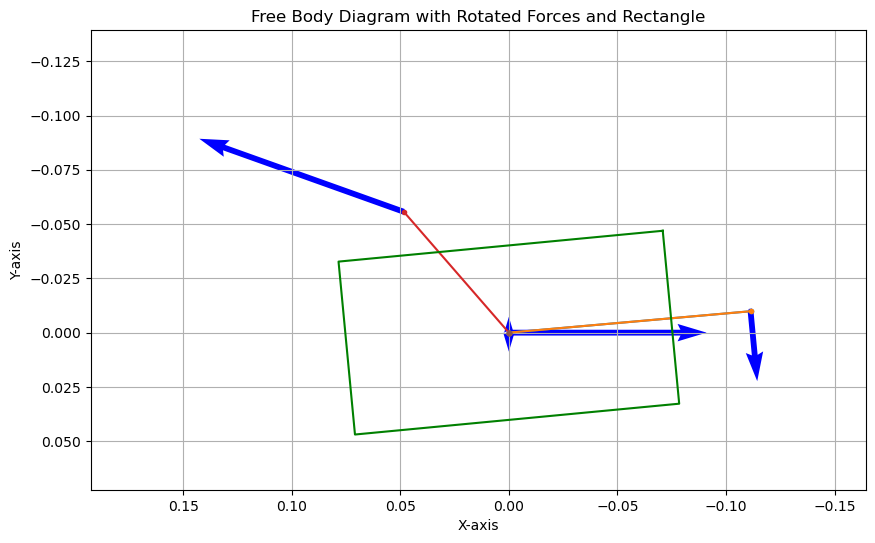

In [80]:
# Define the rotation angle in radians
theta = -sim.sim.pitch_angle[0] # Rotate by pitch (adjust as needed)

# Rotation matrix
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])

# Define forces with their points of application (relative to origin)
forces = [
    {"point": (r_xi, r_zi), "vector": (0, sim.control_force_z)},            # Control z-force
    {"point": (r_xi, r_zi), "vector": (sim.control_force_x, 0)},            # Control x-force
    {"point": (r_xh, r_zh), "vector": (sim.hull_force_x, sim.hull_force_z)}, # Hull drag
    {"point": (r_xt, r_zt), "vector": (sim.tow_force_x, sim.tow_force_z)},   # Tow force
    {"point": (r_xb, r_zb), "vector": (sim.buoyancy_force_x, sim.buoyancy_force_z)}, # Buoyancy
    {"point": (0, 0), "vector": (sim.mass_force_x, sim.mass_force_z)}       # Weight
]

# Determine the maximum length of the vectors
max_length = max(np.linalg.norm(force['vector']) for force in forces)

# Specify the desired maximum length on the plot
desired_max_length = 0.1

# Calculate scaling factor
scaling_factor = desired_max_length / max_length if max_length > 0 else 1

# Define rectangle properties
rect_center = (0,0)  # Center of the rectangle
rect_width, rect_height = 0.15,.08

# Define rectangle corners (before rotation)
corners = [
    (rect_center[0] - rect_width / 2, rect_center[1] - rect_height / 2),  # Bottom-left
    (rect_center[0] + rect_width / 2, rect_center[1] - rect_height / 2),  # Bottom-right
    (rect_center[0] + rect_width / 2, rect_center[1] + rect_height / 2),  # Top-right
    (rect_center[0] - rect_width / 2, rect_center[1] + rect_height / 2)   # Top-left
]

# Rotate forces and rectangle corners
transformed_forces = []
for force in forces:
    # Transform point and vector
    rotated_point = np.dot(rotation_matrix, force["point"])
    rotated_vector = np.dot(rotation_matrix, force["vector"])

    # Scale the rotated vector
    scaled_vector = rotated_vector * scaling_factor
    
    # Store transformed point and vector
    transformed_forces.append({"point": rotated_point, "vector": scaled_vector})

# Rotate rectangle corners
rotated_corners = [np.dot(rotation_matrix, corner) for corner in corners]
rotated_corners.append(rotated_corners[0])  # Close the rectangle by repeating the first point

# Calculate limits based on rotated forces and rectangle
padding = 0.05
x_min = min(point[0] + vector[0] for force in transformed_forces for point, vector in zip([force['point']], [force['vector']])) - padding
x_max = max(point[0] + vector[0] for force in transformed_forces for point, vector in zip([force['point']], [force['vector']])) + padding
y_min = min(point[1] + vector[1] for force in transformed_forces for point, vector in zip([force['point']], [force['vector']])) - padding
y_max = max(point[1] + vector[1] for force in transformed_forces for point, vector in zip([force['point']], [force['vector']])) + padding

# Set up plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

# Set axis limits
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Plot transformed forces
for force in transformed_forces:
    point = force["point"]
    vector = force["vector"]
    ax.quiver(point[0], point[1], vector[0], vector[1], angles='xy', scale_units='xy', scale=1, color='blue')
    ax.plot([0,point[0]], [0,point[1]],'.-')

# Plot the rotated rectangle
rotated_x = [corner[0] for corner in rotated_corners]
rotated_y = [corner[1] for corner in rotated_corners]
ax.plot(rotated_x, rotated_y, 'g-')  # Green rectangle outline

# Flip the appearance of the axes without changing vector directions
ax.invert_xaxis()  # Flip x-axis appearance
ax.invert_yaxis()  # Flip y-axis appearance

# Optional: Add grid, labels, and title
plt.grid(True)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Free Body Diagram with Rotated Forces and Rectangle')

plt.show()

In [75]:
import pandas as pd 


In [76]:
df = pd.DataFrame(forces)
df.columns = ['Point of Application', 'Force Vector']

# Print table
print(df)

               Point of Application  \
0  (-0.11176000000000001, 0.000722)   
1  (-0.11176000000000001, 0.000722)   
2                            (0, 0)   
3                  (0.0429, -0.035)   
4                            (0, 0)   
5                            (0, 0)   

                                 Force Vector  
0                      (0, 17.84944728676826)  
1                     (0.3429094662613117, 0)  
2     (-89.72206414566658, 7.067616673313026)  
3      (89.2683442116274, -26.32378202659312)  
4  (-0.5648042111262097, -7.1700832123162845)  
5     (0.6756146806520121, 8.576801277876704)  
